# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [87]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV



import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [51]:
#pd.read_csv("assets/20001datasciencejobs.csv")
jobs = pd.read_csv("assets/indeed-scraped-job-postings.csv")

In [52]:
print jobs.info()
print jobs.describe()
jobs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
city             413 non-null object
company          413 non-null object
salary           413 non-null object
summary          413 non-null object
title            413 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.4+ KB
None
       parsed_salary
count     406.000000
mean   107762.695813
std     48931.367632
min     10000.000000
25%     70000.000000
50%    100000.000000
75%    142164.500000
max    300000.000000


,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0


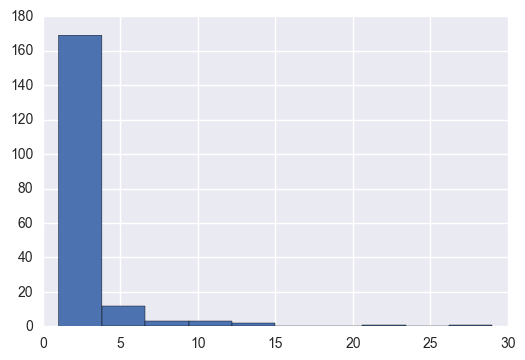

In [53]:
jobs.groupby(["company"]).agg("count")["city"].hist()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

Mean of parsed salaries: 107762.695813
Median of parsed salaries: 100000.0


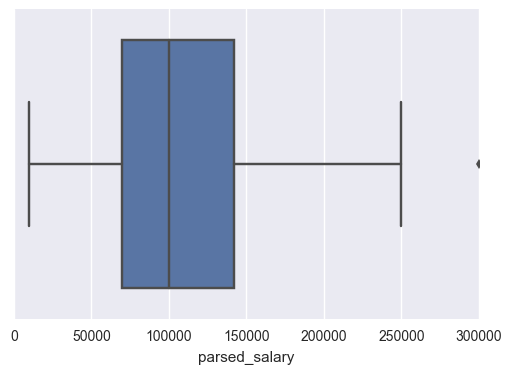

In [54]:
## YOUR CODE HERE
print "Mean of parsed salaries:",jobs["parsed_salary"].mean()
print "Median of parsed salaries:",jobs["parsed_salary"].median()
sns.boxplot(jobs["parsed_salary"])

In [55]:
jobs["high_low"] = jobs["parsed_salary"].apply(lambda x: 1 if x > jobs["parsed_salary"].median() else 0)

#### Thought experiment: What is the baseline accuracy for this model?

In [56]:
## YOUR CODE HERE
class_sizes = list(jobs[jobs["parsed_salary"].isnull() == False].groupby("high_low").agg('count')["parsed_salary"])
baseline_accuracy = max(class_sizes) * 1.0 / sum(class_sizes)
print "The baseline accuracy is given by predicting all results to be in the most prominent class.\n\
In this case it is given by:",baseline_accuracy

The baseline accuracy is given by predicting all results to be in the most prominent class.
In this case it is given by: 0.512315270936


#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [57]:
y = jobs["high_low"]
X = pd.get_dummies(jobs["city"],columns=["city"])
X = sm.add_constant(X, prepend=False)

logistic_model = sm.Logit(endog=y,exog=X).fit()

         Current function value: 0.593851
         Iterations: 35


/Users/dsanford/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [49]:
print "Model Accuracy: ",np.mean([int(i) for i in list((logistic_model.predict(X) > 0.5) == y)])
logistic_model.summary()

Model Accuracy:  0.661016949153


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  413
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                           17
Date:                Sat, 14 Jan 2017   Pseudo R-squ.:                  0.1422
Time:                        20:14:34   Log-Likelihood:                -245.26
converged:                      False   LL-Null:                       -285.92
                                        LLR p-value:                 2.234e-10
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Atlanta           8.8315   2.51e+06   3.52e-06      1.000     -4.91e+06  4.91e+06
Austin            9.8656   2.51e+06   3.94e-06      1.000     -4.91e+06  4.91e+06
Boston           10.9110   2.51e+06   4.35e-06      1.000     -4.91e+06  4.91e+06
Chicago          10.2645   2.51e+06    4.1e-06      1.000     -4.91e+06  4.91e+06
Dallas            9.4601   2.51e+06   3.78e-06      1.000     -4.91e+06  4.91e+06
Denver            8.6128   2.51e+06   3.44e-06      1.000     -4.91e+06  4.91e+06
Houston         -58.6093   2.85e+14  -2.06e-13      1.000     -5.58e+14  5.58e+14
Los+Angeles      10.1533   2.51e+06   4.05e-06      1.000     -4.91e+06  4.91e+06
Miami             8.5438   2.51e+06   3.41e-06      1.000     -4.91e+06  4.91e+06
New+York          9.8201   2.51e+06   3.92e-06      1.000     -4.91e+06  4.91e+06
Palo+Alto        11.0183   2.51e+06    4.4e-06      1.000     -4.91e+06  4.91e+06
Philadelphia     10.7129   2.51e+06   4.28e-06      1.000     -4.91e+06  4.91e+06
Phoenix          -8.7402   2.51e+06  -3.49e-06      1.000     -4.91e+06  4.91e+06
Pittsburgh      -59.2228   3.87e+14  -1.53e-13      1.000     -7.58e+14  7.58e+14
Portland        -22.9200   1.54e+07  -1.49e-06      1.000     -3.02e+07  3.02e+07
San+Diego         9.7478   2.51e+06   3.89e-06      1.000     -4.91e+06  4.91e+06
San+Francisco    11.2793   2.51e+06    4.5e-06      1.000     -4.91e+06  4.91e+06
Seattle          10.1533   2.51e+06   4.05e-06      1.000     -4.91e+06  4.91e+06
const           -10.1533   2.51e+06  -4.05e-06      1.000     -4.91e+06  4.91e+06
=================================================================================
"""

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [73]:
## YOUR CODE HERE
y = jobs["high_low"]
X = pd.get_dummies(jobs["city"],columns=["city"])
X = sm.add_constant(X, prepend=False)
X["Senior"] = jobs["title"].apply(lambda x:int("Senior" in x ))
X["Manager"] = jobs["title"].apply(lambda x:int("Manager" in x))
X["Lead"] = jobs["title"].apply(lambda x:int("Lead" in x))
X["Data Scientist"] = jobs["title"].apply(lambda x:int("Data Scientist" in x))
X["Data Analyst"] = jobs["title"].apply(lambda x:int("Data Analyst" in x))
X["Statistician"] = jobs["title"].apply(lambda x:int("Statistician" in x))
logistic_model = sm.Logit(endog=y,exog=X).fit()

         Current function value: 0.505026
         Iterations: 35


/Users/dsanford/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [74]:
print "Model Accuracy: ",np.mean([int(i) for i in list((logistic_model.predict(X) > 0.5) == y)])
logistic_model.summary()

Model Accuracy:  0.760290556901


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  413
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                           23
Date:                Sat, 14 Jan 2017   Pseudo R-squ.:                  0.2705
Time:                        20:22:45   Log-Likelihood:                -208.58
converged:                      False   LL-Null:                       -285.92
                                        LLR p-value:                 1.680e-21
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Atlanta            4.3549   6.64e+06   6.56e-07      1.000      -1.3e+07   1.3e+07
Austin             4.4657   6.64e+06   6.72e-07      1.000      -1.3e+07   1.3e+07
Boston             5.9267   6.64e+06   8.92e-07      1.000      -1.3e+07   1.3e+07
Chicago            5.2570   6.64e+06   7.91e-07      1.000      -1.3e+07   1.3e+07
Dallas             4.7315   6.64e+06   7.12e-07      1.000      -1.3e+07   1.3e+07
Denver             3.8265   6.64e+06   5.76e-07      1.000      -1.3e+07   1.3e+07
Houston          -16.6356   6.64e+06   -2.5e-06      1.000      -1.3e+07   1.3e+07
Los+Angeles        5.6299   6.64e+06   8.47e-07      1.000      -1.3e+07   1.3e+07
Miami              3.5008   6.64e+06   5.27e-07      1.000      -1.3e+07   1.3e+07
New+York           4.8920   6.64e+06   7.36e-07      1.000      -1.3e+07   1.3e+07
Palo+Alto          5.7779   6.64e+06    8.7e-07      1.000      -1.3e+07   1.3e+07
Philadelphia       5.5506   6.64e+06   8.36e-07      1.000      -1.3e+07   1.3e+07
Phoenix          -15.7812   6.64e+06  -2.38e-06      1.000      -1.3e+07   1.3e+07
Pittsburgh       -21.8786   6.65e+06  -3.29e-06      1.000      -1.3e+07   1.3e+07
Portland         -21.5790   6.67e+06  -3.24e-06      1.000     -1.31e+07  1.31e+07
San+Diego          5.0313   6.64e+06   7.57e-07      1.000      -1.3e+07   1.3e+07
San+Francisco      6.1513   6.64e+06   9.26e-07      1.000      -1.3e+07   1.3e+07
Seattle            5.0104   6.64e+06   7.54e-07      1.000      -1.3e+07   1.3e+07
const             -5.7677   6.64e+06  -8.68e-07      1.000      -1.3e+07   1.3e+07
Senior             0.7937      0.389      2.039      0.041         0.031     1.557
Manager            0.2924      0.475      0.615      0.539        -0.639     1.224
Lead               1.3391      1.103      1.214      0.225        -0.822     3.500
Data Scientist     1.9880      0.318      6.251      0.000         1.365     2.611
Data Analyst      -2.4861      1.140     -2.180      0.029        -4.721    -0.251
Statistician      -0.1271      0.622     -0.204      0.838        -1.346     1.092
==================================================================================
"""

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [92]:
y = jobs["high_low"]
X = pd.get_dummies(jobs["city"],columns=["city"])
X = sm.add_constant(X, prepend=False)
logistic_model = LogisticRegression().fit(X,y)
print "Model Accuracy: ",logistic_model.score(X,y)

Model Accuracy:  0.661016949153


In [93]:
y = jobs["high_low"]
X = pd.get_dummies(jobs["city"],columns=["city"])
X = sm.add_constant(X, prepend=False)
X["Senior"] = jobs["title"].apply(lambda x:int("Senior" in x ))
X["Manager"] = jobs["title"].apply(lambda x:int("Manager" in x))
X["Lead"] = jobs["title"].apply(lambda x:int("Lead" in x))
X["Data Scientist"] = jobs["title"].apply(lambda x:int("Data Scientist" in x))
X["Data Analyst"] = jobs["title"].apply(lambda x:int("Data Analyst" in x))
X["Statistician"] = jobs["title"].apply(lambda x:int("Statistician" in x))
logistic_model = LogisticRegression().fit(X,y)
print "Model Accuracy: ",logistic_model.score(X,y)

Model Accuracy:  0.760290556901


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [116]:
## YOUR CODE HERE
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print "Accuracy metrics for 10-fold cross-validation"
print "Accuracy   ",np.mean(cross_val_score(LogisticRegressionCV(penalty='l1',solver='liblinear'),
                                            X,y,cv=10,scoring='accuracy'))
print "ROC AUC    ",np.mean(cross_val_score(LogisticRegressionCV(penalty='l1',solver='liblinear'),
                                            X,y,cv=10,scoring='roc_auc'))
print "Precision  ",np.mean(cross_val_score(LogisticRegressionCV(penalty='l1',solver='liblinear'),
                                            X,y,cv=10,scoring='precision'))
print "Recall     ",np.mean(cross_val_score(LogisticRegressionCV(penalty='l1',solver='liblinear'),
                                            X,y,cv=10,scoring='recall'))


Accuracy metrics for 10-fold cross-validation
Accuracy    0.706611498258
ROC AUC     0.7269628617
Precision   0.806760739261
Recall      0.515526315789


#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [21]:
## YOUR CODE HERE


In [22]:
## YOUR CODE HERE

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [319]:
## YOUR CODE HERE
from  sklearn.feature_extraction.text import CountVectorizer

tokenizer = CountVectorizer().build_tokenizer()
tokenizer("hi, I'm a tokenizer")
jobs["summary"].apply(tokenizer)

#jobs["summary"].apply(CountVectorizer())
test = CountVectorizer().fit(["hi, I'm a tokenizer"])
test.

In [25]:
print len(summary_cut),len(title_cut)

121 35


jobs["summary_list"] = jobs["summary"].apply(str.split)
jobs["title_list"] = jobs["summary"].apply(str.split)
summary_entries = list(set([l for sublist in list(jobs["summary_list"]) for l in sublist]))
title_entries = list(set([l for sublist in list(jobs["title_list"]) for l in sublist]))

min_entries = 10
cut_threshold = 0.1

summary_cut = [word for word in summary_entries if (jobs[jobs["summary"].apply(lambda x:word in x)].shape[0] > min_entries and
    abs(jobs[jobs["summary"].apply(lambda x:word in x)]["high_low"].mean() - baseline_accuracy) > cut_threshold)]

title_cut = [word for word in title_entries if (jobs[jobs["title"].apply(lambda x:word in x)].shape[0] > min_entries and
    abs(jobs[jobs["title"].apply(lambda x:word in x)]["high_low"].mean() - baseline_accuracy) > cut_threshold)]

In [229]:
y = jobs["high_low"]
X = pd.get_dummies(jobs["city"],columns=["city"])
for word in summary_cut:
    X["summary_"+word] = jobs["summary"].apply(lambda x:int(word in x))
    
for word in title_cut:
    X["title_"+word] = jobs["title"].apply(lambda x:int(word in x))

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE